In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Dataset
from torchvision import models, transforms
from tensorboardX import SummaryWriter

from imutils import paths

import matplotlib.pyplot as plt
from PIL import Image

In [29]:
print(torch.__version__)

1.8.1+cu102


## 自定义dataset

In [2]:
class MyDataSet(Dataset):
    def __init__(self, file_path, label_dict, transform = None):
        self.images = list(paths.list_images(file_path))
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = Image.open(self.images[index]).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = np.asarray(image)
            image = torch.from_numpy(image)
            
        label = label_dict[self.images[index].split("/")[2]]
        
        return image, label

- 图像的均值和方差

In [3]:
image_mean = (0.4914, 0.4822, 0.4465)
image_std = (0.229, 0.224, 0.225)

- 变换

In [4]:
transform_train = transforms.Compose([
    #transforms.ToPILImage(),
#     transforms.RandomResizedCrop(224),  #把图像裁剪成270*270
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),  #图像一半的概率翻转，一半的概率不翻转
    #ransforms.RandomRotation((-45,45)), #随机旋转
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std), #R,G,B每层的归一化用到的均值和方差
])
transform_val = transforms.Compose([
#     transforms.RandomResizedCrop(224),  #把图像裁剪成270*270
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std), #R,G,B每层的归一化用到的均值和方差
])

In [5]:
data_transforms = {"train": transform_train, "val": transform_val}

In [6]:
label_dict = {"crosswalk":0, "grass":1, "house":2, "red":3, "yellow":4, "green": 5, "turn_left":6, "turn_right":7, "stop":8}
mydata = {x: MyDataSet(os.path.join("dataset-pytorch", x), label_dict, data_transforms[x]) for x in ("train", "val")}

In [7]:
dataset_sizes = {x: len(mydata[x]) for x in ("train", "val")}
print(dataset_sizes)

{'train': 7559, 'val': 836}


In [8]:
def image_show(image):
    img = image.numpy().transpose((1,2,0))
    mean = np.array(image_mean)
    std = np.array(image_std)
    img = img*std + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()

torch.Size([3, 224, 224]) <class 'torch.Tensor'>


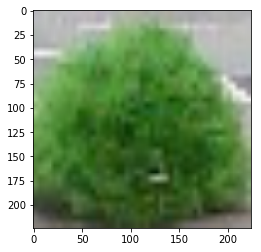

1


In [9]:
image, label = mydata["train"][0]
print(image.shape, type(image))
# image_show = transforms.ToPILImage()(image)
image_show(image)
# plt.imshow(image_show)
# plt.show()
print(label)

## 使用torch封装的ImageFolder

In [10]:
# myimages = ImageFolder('dataset', transform=transform)
# print(myimages.class_to_idx)
# print(myimages[0][0].size())

## dataloader

In [11]:
# batch_size(每个batch的大小)、 shuffle(是否进行shuffle操作)、 num_workers(加载数据的时候使用几个子进程)
dataloaders = {x:DataLoader(mydata[x], batch_size=64, shuffle=True, num_workers=0) for x in ("train", "val")}

In [12]:
for index, data in enumerate(dataloaders["train"]):
    print(index, data[0].size())
    break

0 torch.Size([64, 3, 224, 224])


In [13]:
for data, label in dataloaders["train"]:
    print(label)
    break

tensor([4, 8, 2, 8, 8, 8, 4, 5, 3, 5, 4, 3, 8, 2, 5, 7, 2, 4, 3, 6, 5, 5, 3, 4,
        2, 5, 2, 3, 3, 8, 3, 4, 3, 4, 6, 3, 3, 2, 3, 6, 6, 2, 2, 2, 3, 5, 8, 2,
        3, 3, 5, 4, 3, 5, 3, 4, 2, 5, 4, 2, 5, 5, 3, 3])


**==============分割线===============**

## model

In [14]:
model_ft = models.resnet50(pretrained=True) # 这里自动下载官方的预训练模型，并且将所有的参数层进行冻结
for param in model_ft.parameters():
    param.requires_grad = False
# print(model_ft.fc)
num_fc_ftr = model_ft.fc.in_features #获取到fc层的输入
model_ft.fc = nn.Linear(num_fc_ftr, 9) # 定义一个新的FC层
# print(model_ft)

In [15]:
# 下载vgg16模型
model_vgg = torchvision.models.vgg16(pretrained=False) #我们不下载预训练权重

In [16]:
# vgg16
class MyModel(nn.Module):
    def __init__(self, fc_number1, fc_number2, output_number):
        super(MyModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            # 修改
#             nn.MaxPool2d(4),
        )
        self.linear = nn.Sequential(
            nn.Linear(512*7*7, fc_number1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(fc_number1, fc_number2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(fc_number2, output_number),
            nn.Softmax(dim=1)
#             nn.Linear(512*1*1, fc_number1),
#             nn.ELU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(fc_number1, fc_number2),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(fc_number1, output_number),
#             nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)
        return x

In [17]:
mymodel = MyModel(4096,512,9)
# mymodel = MyModel(64,0,9)

In [18]:
# mymodel

## train_test

In [19]:
writer = SummaryWriter("covid")

<div class="alert alert-success" role="success">写法1</div>

In [20]:
def train_model(model, criterion, optimizer, scheduler, epochs = 25):
    best_acc = 0.0
    for epoch in range(epochs):
        print("epoch: {}/{}".format(epoch, epochs))
        print("*"*10)
        for phase in ("train", "val"):
            if "train" == phase:
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            
            for i, data in enumerate(dataloaders[phase]):
                inputs, labels = data
                optimizer.zero_grad()
                with torch.set_grad_enabled("train" == phase):
                    outputs = model(inputs)
                    _, predict = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    print("[{}, {}] loss: {}".format(epoch, i, loss.item()))
                
                    if "train" == phase:
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                running_loss += loss.item()
                running_corrects += torch.sum(predict == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print("{} loss: {}, Acc:{}".format(epoch, epoch_loss, epoch_acc))
            if "train" == phase:      
                writer.add_scalar("train/loss", epoch_loss, epoch)
                writer.add_scalar("train/acc", epoch_acc, epoch)
            else:
                writer.add_scalar("val/loss", epoch_loss, epoch)
                writer.add_scalar("val/acc", epoch_acc, epoch)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
    writer.close()
    return model

In [21]:
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(mymodel.parameters(), lr=0.1)
# optimizer = torch.optim.Adam([
#     {'params':mymodel.parameters()}
# ], lr=0.001)
optimizer = torch.optim.Adam([
    {'params':model_ft.fc.parameters()}
], lr=0.001)#指定 新加的fc层的学习率
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [22]:
#net = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, epochs=10)

<div class="alert alert-success" role="success">写法2</div>

In [23]:
def train(model, criterion, optimizer, device, train_loader, epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        x,y= data
#         x=x.to(device)
#         y=y.to(device)
        optimizer.zero_grad()
        y_hat= model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        print("{}/{} loss:{}".format(batch_idx+1, epoch, loss.item()))
    print ('Train Epoch: {}\t Loss: {:.6f}'.format(epoch,loss.item()))

In [24]:
def test(model, criterion, optimizer, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i,data in enumerate(test_loader):          
            x,y= data
#             x=x.to(device)
#             y=y.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            test_loss += criterion(y_hat, y).item() # sum up batch loss
            pred = y_hat.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(y.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print("i:",i)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(mydata["val"]),
        100. * correct / len(mydata["val"])))

In [26]:
for epoch in range(1, 20):
    %time train(model_ft, criterion, optimizer, device="cpu", train_loader=dataloaders["train"],epoch=epoch)
    test(model_ft, criterion, optimizer, device="cpu", test_loader=dataloaders["val"])

1/1 loss:0.08356035500764847
2/1 loss:0.08454636484384537
3/1 loss:0.035955946892499924
4/1 loss:0.06775876134634018
5/1 loss:0.12060993164777756
6/1 loss:0.14953844249248505
7/1 loss:0.04605880379676819
8/1 loss:0.08476293087005615
9/1 loss:0.08932047337293625
10/1 loss:0.16721434891223907
11/1 loss:0.08561715483665466
12/1 loss:0.1381785273551941
13/1 loss:0.19414521753787994
14/1 loss:0.1278700977563858
15/1 loss:0.12747187912464142
16/1 loss:0.1349407285451889
17/1 loss:0.1165177971124649
18/1 loss:0.11174941062927246
19/1 loss:0.15495403110980988
20/1 loss:0.09356105327606201
21/1 loss:0.18851542472839355
22/1 loss:0.06869810819625854
23/1 loss:0.18884921073913574
24/1 loss:0.11995755881071091
25/1 loss:0.0811598151922226
26/1 loss:0.14018647372722626
27/1 loss:0.13444656133651733
28/1 loss:0.035941772162914276
29/1 loss:0.09877565503120422
30/1 loss:0.08111817389726639
31/1 loss:0.035380393266677856
32/1 loss:0.09680740535259247
33/1 loss:0.14813339710235596
34/1 loss:0.144423574

26/3 loss:0.09602949768304825
27/3 loss:0.12458694726228714
28/3 loss:0.16460387408733368
29/3 loss:0.11173471808433533
30/3 loss:0.07257960736751556
31/3 loss:0.0818428099155426
32/3 loss:0.10716318339109421
33/3 loss:0.15282583236694336
34/3 loss:0.22274214029312134
35/3 loss:0.06885027885437012
36/3 loss:0.1083870604634285
37/3 loss:0.06914004683494568
38/3 loss:0.13831321895122528
39/3 loss:0.1001361533999443
40/3 loss:0.0628284439444542
41/3 loss:0.1673114001750946
42/3 loss:0.10919841378927231
43/3 loss:0.044509753584861755
44/3 loss:0.062064316123723984
45/3 loss:0.10814166814088821
46/3 loss:0.0889834389090538
47/3 loss:0.06199854239821434
48/3 loss:0.13196060061454773
49/3 loss:0.13529258966445923
50/3 loss:0.1005946695804596
51/3 loss:0.1380983591079712
52/3 loss:0.15933147072792053
53/3 loss:0.07559388130903244
54/3 loss:0.17241595685482025
55/3 loss:0.07688213884830475
56/3 loss:0.11896627396345139
57/3 loss:0.058976758271455765
58/3 loss:0.09990045428276062
59/3 loss:0.085

51/5 loss:0.15638403594493866
52/5 loss:0.11773905903100967
53/5 loss:0.16214245557785034
54/5 loss:0.048874907195568085
55/5 loss:0.11025037616491318
56/5 loss:0.08982797712087631
57/5 loss:0.07284475117921829
58/5 loss:0.07699272036552429
59/5 loss:0.05275743454694748
60/5 loss:0.06213456019759178
61/5 loss:0.15341277420520782
62/5 loss:0.0862886905670166
63/5 loss:0.07462678849697113
64/5 loss:0.11590863019227982
65/5 loss:0.09611993283033371
66/5 loss:0.1307915300130844
67/5 loss:0.0726366862654686
68/5 loss:0.13602206110954285
69/5 loss:0.0483495369553566
70/5 loss:0.045950017869472504
71/5 loss:0.08104293793439865
72/5 loss:0.16322852671146393
73/5 loss:0.10797718167304993
74/5 loss:0.09061463177204132
75/5 loss:0.13744337856769562
76/5 loss:0.1372140347957611
77/5 loss:0.06537334620952606
78/5 loss:0.11001458764076233
79/5 loss:0.15271912515163422
80/5 loss:0.09670594334602356
81/5 loss:0.22517181932926178
82/5 loss:0.2098044604063034
83/5 loss:0.060854796320199966
84/5 loss:0.0

75/7 loss:0.10908971726894379
76/7 loss:0.1335083395242691
77/7 loss:0.07470786571502686
78/7 loss:0.19124835729599
79/7 loss:0.06745008379220963
80/7 loss:0.1592891961336136
81/7 loss:0.08748822659254074
82/7 loss:0.08398447930812836
83/7 loss:0.09891428798437119
84/7 loss:0.13626180589199066
85/7 loss:0.13076594471931458
86/7 loss:0.07713955640792847
87/7 loss:0.13027094304561615
88/7 loss:0.04831487312912941
89/7 loss:0.13110752403736115
90/7 loss:0.07161371409893036
91/7 loss:0.0754811018705368
92/7 loss:0.08113580197095871
93/7 loss:0.14605368673801422
94/7 loss:0.08894956111907959
95/7 loss:0.10025302320718765
96/7 loss:0.05852694436907768
97/7 loss:0.1592055708169937
98/7 loss:0.07471167296171188
99/7 loss:0.052170902490615845
100/7 loss:0.10439246147871017
101/7 loss:0.12269138544797897
102/7 loss:0.03947879374027252
103/7 loss:0.14823155105113983
104/7 loss:0.06089901551604271
105/7 loss:0.06774718314409256
106/7 loss:0.09376412630081177
107/7 loss:0.06582330912351608
108/7 lo

100/9 loss:0.1485787034034729
101/9 loss:0.041059959679841995
102/9 loss:0.13670992851257324
103/9 loss:0.12642362713813782
104/9 loss:0.07285613566637039
105/9 loss:0.0932246744632721
106/9 loss:0.1422606110572815
107/9 loss:0.18335309624671936
108/9 loss:0.08035010099411011
109/9 loss:0.04744720458984375
110/9 loss:0.10318626463413239
111/9 loss:0.08819602429866791
112/9 loss:0.14790098369121552
113/9 loss:0.11886490136384964
114/9 loss:0.0838012546300888
115/9 loss:0.10437491536140442
116/9 loss:0.08519183844327927
117/9 loss:0.15035919845104218
118/9 loss:0.11312036961317062
119/9 loss:0.3021504282951355
Train Epoch: 9	 Loss: 0.302150
CPU times: user 38min 34s, sys: 6min 57s, total: 45min 32s
Wall time: 6min 3s
i: 13

Test set: Average loss: 0.0014, Accuracy: 809/836 (97%)

1/10 loss:0.040301449596881866
2/10 loss:0.08125396072864532
3/10 loss:0.04196557402610779
4/10 loss:0.23223088681697845
5/10 loss:0.07328856736421585
6/10 loss:0.06990347802639008
7/10 loss:0.14597100019454956


116/11 loss:0.07409248501062393
117/11 loss:0.09254149347543716
118/11 loss:0.19013866782188416
119/11 loss:0.3386475741863251
Train Epoch: 11	 Loss: 0.338648
CPU times: user 38min 26s, sys: 6min 57s, total: 45min 24s
Wall time: 6min 1s
i: 13

Test set: Average loss: 0.0019, Accuracy: 794/836 (95%)

1/12 loss:0.08701982349157333
2/12 loss:0.1017785295844078
3/12 loss:0.06798118352890015
4/12 loss:0.2279626578092575
5/12 loss:0.1565045863389969
6/12 loss:0.045022569596767426
7/12 loss:0.15230435132980347
8/12 loss:0.1275540590286255
9/12 loss:0.06678394973278046
10/12 loss:0.04702453315258026
11/12 loss:0.0574677512049675
12/12 loss:0.06015707179903984
13/12 loss:0.08541208505630493
14/12 loss:0.12731891870498657
15/12 loss:0.15957511961460114
16/12 loss:0.06438883394002914
17/12 loss:0.0657636895775795
18/12 loss:0.16160129010677338
19/12 loss:0.10581287741661072
20/12 loss:0.09996799379587173
21/12 loss:0.07892382889986038
22/12 loss:0.1561901718378067
23/12 loss:0.0416080616414547
24

7/14 loss:0.17245791852474213
8/14 loss:0.07426200062036514
9/14 loss:0.10762886703014374
10/14 loss:0.06251417845487595
11/14 loss:0.06430771946907043
12/14 loss:0.144452765583992
13/14 loss:0.11050929129123688
14/14 loss:0.19831059873104095
15/14 loss:0.1593659520149231
16/14 loss:0.045894935727119446
17/14 loss:0.09098749607801437
18/14 loss:0.13364188373088837
19/14 loss:0.09893686324357986
20/14 loss:0.09723823517560959
21/14 loss:0.05006932094693184
22/14 loss:0.15263304114341736
23/14 loss:0.059094808995723724
24/14 loss:0.052892446517944336
25/14 loss:0.1865861564874649
26/14 loss:0.11967360228300095
27/14 loss:0.07765771448612213
28/14 loss:0.03848232328891754
29/14 loss:0.07071150094270706
30/14 loss:0.08552324026823044
31/14 loss:0.08183075487613678
32/14 loss:0.038649771362543106
33/14 loss:0.14013171195983887
34/14 loss:0.13182294368743896
35/14 loss:0.1112225353717804
36/14 loss:0.0600411556661129
37/14 loss:0.05641501396894455
38/14 loss:0.08200245350599289
39/14 loss:0.

22/16 loss:0.0736323893070221
23/16 loss:0.07138867676258087
24/16 loss:0.049243468791246414
25/16 loss:0.12986843287944794
26/16 loss:0.10679905116558075
27/16 loss:0.1264168918132782
28/16 loss:0.09381138533353806
29/16 loss:0.12111742049455643
30/16 loss:0.08879920095205307
31/16 loss:0.062063150107860565
32/16 loss:0.07554272562265396
33/16 loss:0.15940670669078827
34/16 loss:0.09734372794628143
35/16 loss:0.05060652270913124
36/16 loss:0.07336673885583878
37/16 loss:0.09989132732152939
38/16 loss:0.07162454724311829
39/16 loss:0.20456252992153168
40/16 loss:0.08691518753767014
41/16 loss:0.0543694905936718
42/16 loss:0.09703050553798676
43/16 loss:0.06492253392934799
44/16 loss:0.0662383958697319
45/16 loss:0.06802587956190109
46/16 loss:0.128035306930542
47/16 loss:0.11556234210729599
48/16 loss:0.02724122814834118
49/16 loss:0.10866988450288773
50/16 loss:0.10451076179742813
51/16 loss:0.07014685124158859
52/16 loss:0.06729098409414291
53/16 loss:0.06879507750272751
54/16 loss:0

38/18 loss:0.17862744629383087
39/18 loss:0.08471589535474777
40/18 loss:0.0415969118475914
41/18 loss:0.05149511620402336
42/18 loss:0.07533708214759827
43/18 loss:0.09611373394727707
44/18 loss:0.141941100358963
45/18 loss:0.0469394214451313
46/18 loss:0.06292156130075455
47/18 loss:0.06150958687067032
48/18 loss:0.09232722222805023
49/18 loss:0.15443183481693268
50/18 loss:0.05117364972829819
51/18 loss:0.03019029088318348
52/18 loss:0.07679186761379242
53/18 loss:0.030219264328479767
54/18 loss:0.08056724071502686
55/18 loss:0.07540813088417053
56/18 loss:0.038207944482564926
57/18 loss:0.09087507426738739
58/18 loss:0.032407067716121674
59/18 loss:0.10683148354291916
60/18 loss:0.12796804308891296
61/18 loss:0.11967551708221436
62/18 loss:0.08214785158634186
63/18 loss:0.08964499831199646
64/18 loss:0.11095625162124634
65/18 loss:0.0648413598537445
66/18 loss:0.1521821916103363
67/18 loss:0.05825185775756836
68/18 loss:0.0883314460515976
69/18 loss:0.06940530985593796
70/18 loss:0

# 保存模型

## 只保存状态字典

- 只保存状态字典

In [24]:
torch.save(model_ft.state_dict(), "model_ft.pth")

- 加载

In [ ]:
model = ModelClass(*args, **kwargs)
model.load_state_dict(torch.load("model_ft.pth"))

## 保存整个模型

- 保存

In [27]:
torch.save(model_ft, "model_ft_total.pth")

- 加载

In [ ]:
model = torch.load( "model_ft_total.pth")

## 可视化

In [ ]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    
    images_so_far = 0
    plt.figure()
    
    with torch.no_grad():
        for i, data in enumerate(dataloaders["val"]):
            inputs, labels = data
            outputs = model(inputs)
            _, predict = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("predicted:{}".format(predict[j]))
                
                image_show(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
                model.train(mode = was_training)

In [ ]:
visualize_model(net)
plt.ioff()
plt.show()